In [1]:
import pandas as pd
import os

In [2]:
files = [file for file in os.listdir('.') if file.endswith('tuning-machine.csv')]

dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)


In [3]:
whole_df = pd.concat(dfs, axis=0)

In [8]:
df = pd.read_csv('1.2.2_tuning-machine.csv')

In [9]:
columns_to_check = [
    'LOC',
    "LongParameterList", "LongMethod", "LongScopeChaining",
    "LongBaseClassList", "LargeClass", "LongMessageChain",
    "ComplexLambdaExpression", "LongTernaryConditionalExpression",
    "ComplexContainerComprehension", "MultiplyNestedContainer"
]

In [10]:
df_no_smell = df[(df[columns_to_check] == 0).all(axis=1)]
df_smelly = df[(df[columns_to_check] != 0).any(axis=1)]

In [11]:
from scipy.stats import mannwhitneyu
from itertools import product

In [23]:
def cliffs_delta(x, y):
    nx, ny = len(x), len(y)
    greater = sum(1 for i, j in product(x, y) if i > j)
    smaller = sum(1 for i, j in product(x, y) if i < j)
    d = (greater - smaller) / (nx * ny)
    return d

delta = cliffs_delta(df_smelly['change'], df_no_smell['change'])
mannwhitneyu(df_no_smell['change'], df_smelly['change'], alternative='less')


MannwhitneyuResult(statistic=86155.5, pvalue=2.726385038387727e-78)

In [24]:
delta

0.5825081348778496

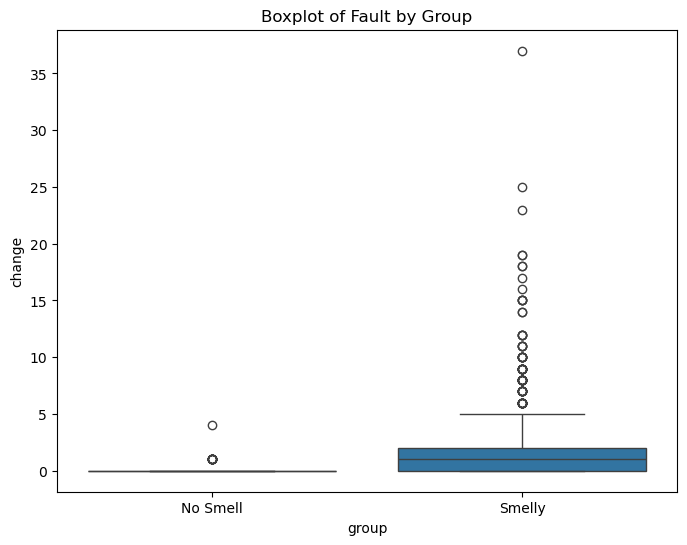

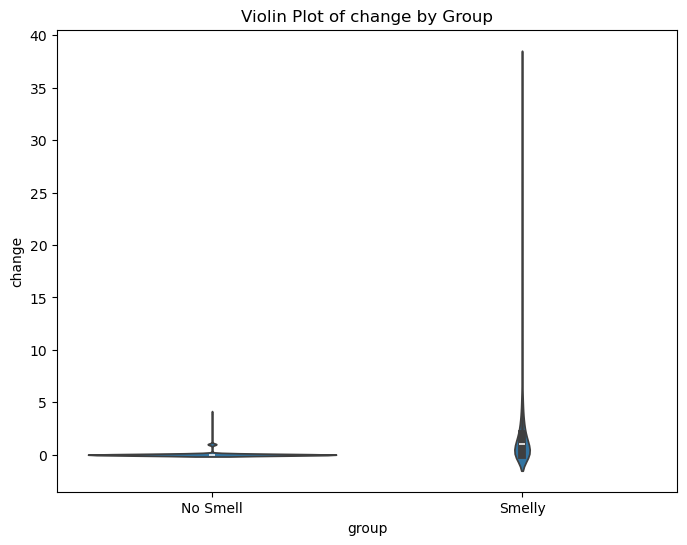

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_no_smell['fault'] and df_smelly['fault'] are the two groups
# You can combine both data into one DataFrame for easier plotting
import pandas as pd

# Create a DataFrame for plotting
data = pd.DataFrame({
    'change': pd.concat([df_no_smell['change'], df_smelly['change']]),
    'group': ['No Smell'] * len(df_no_smell['change']) + ['Smelly'] * len(df_smelly['change'])
})

# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='change', data=data)
plt.title('Boxplot of Fault by Group')
plt.show()

# Create a violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='group', y='change', data=data)
plt.title('Violin Plot of change by Group')
plt.show()


In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import glm
import numpy as np

X = sm.add_constant(whole_df[columns_to_check])

# Dependent variable
y = whole_df['change']

# Fit the Negative Binomial model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
results = model.fit()

# Display the results including p-values
print(results.summary())

/home/aryan/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 change   No. Observations:                22448
Model:                            GLM   Df Residuals:                    22436
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27166.
Date:                Wed, 04 Dec 2024   Deviance:                       21292.
Time:                        01:13:24   Pearson chi2:                 2.71e+04
No. Iterations:                    28   Pseudo R-squ. (CS):             0.2922
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

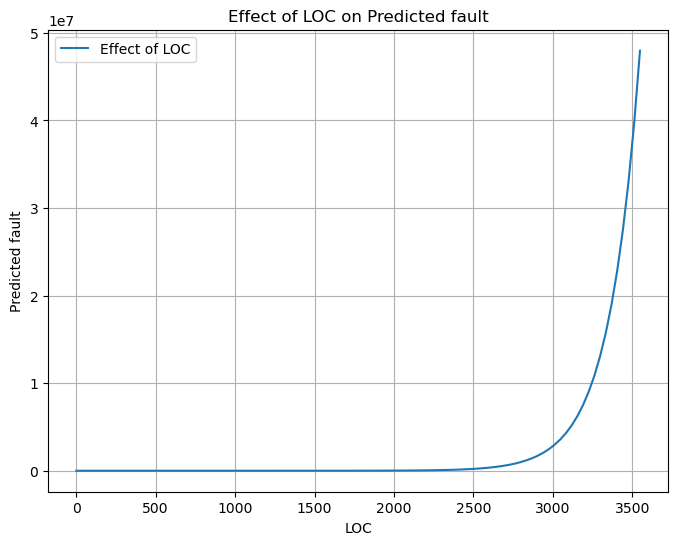

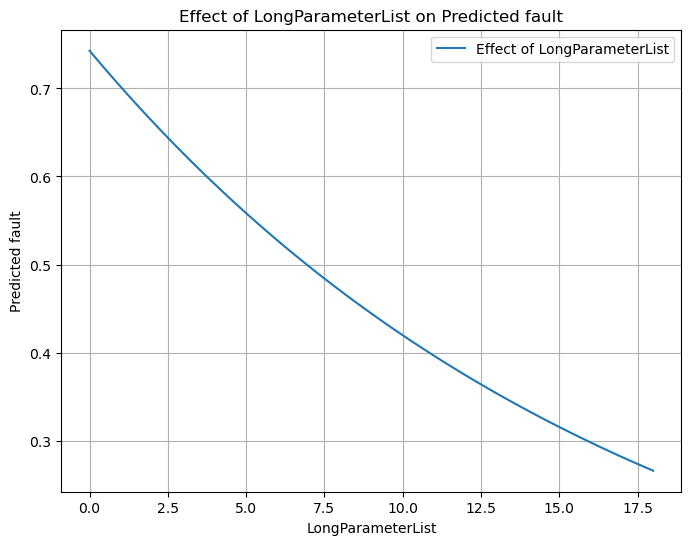

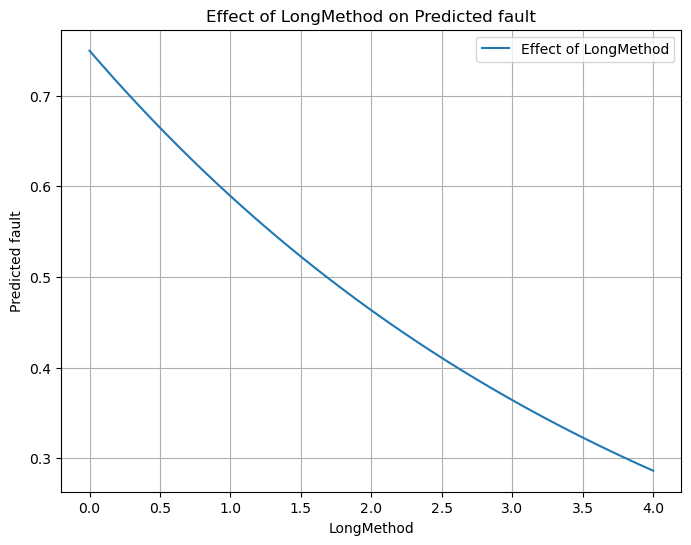

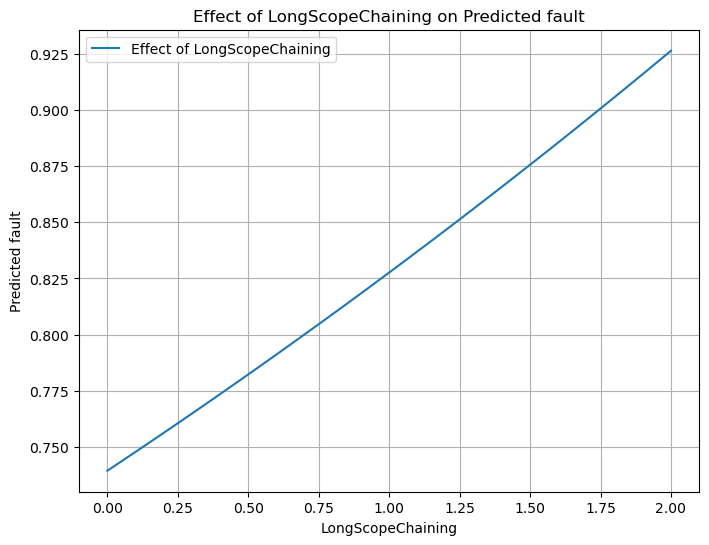

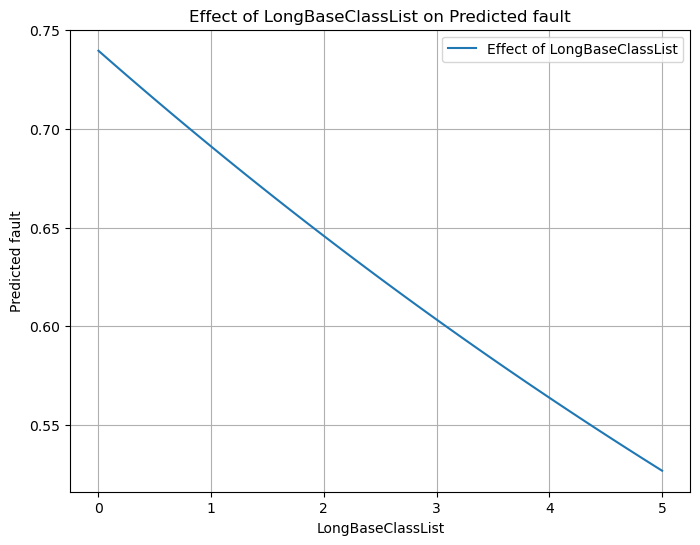

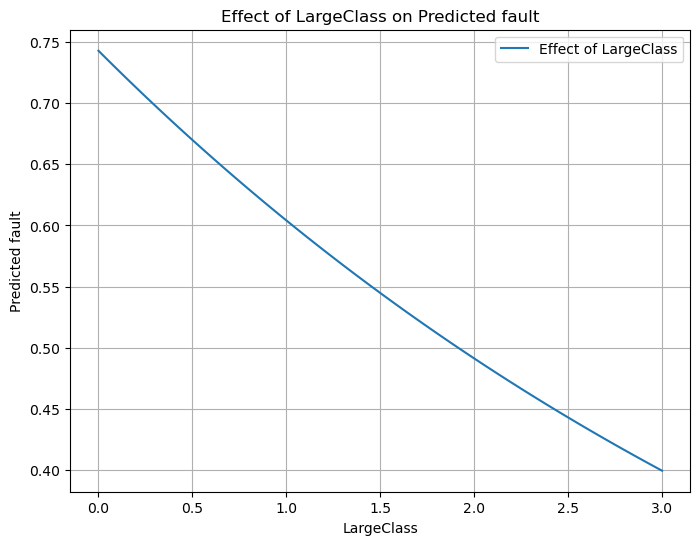

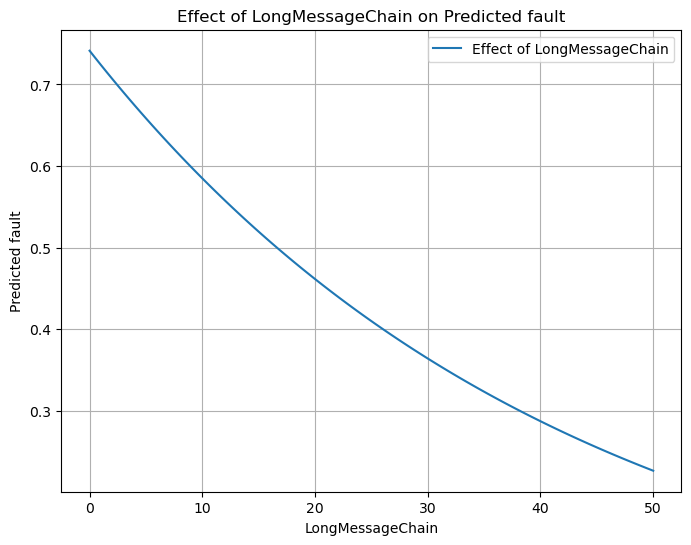

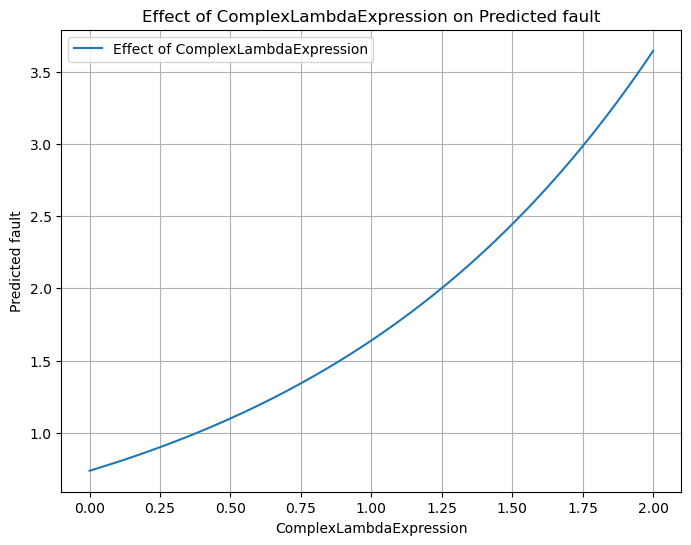

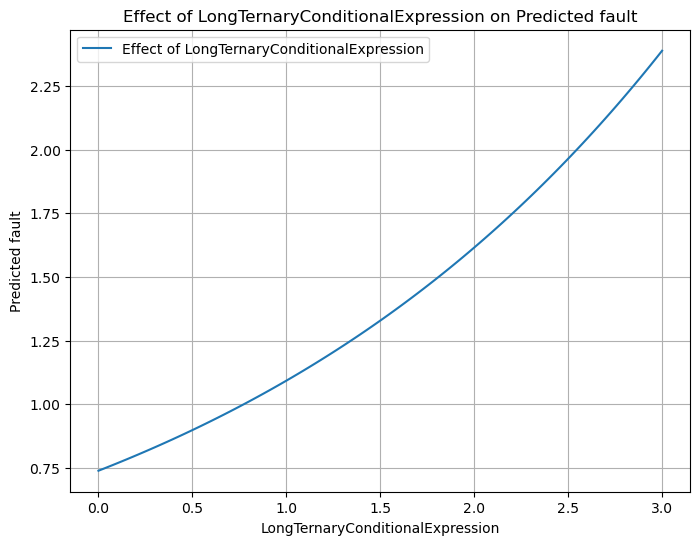

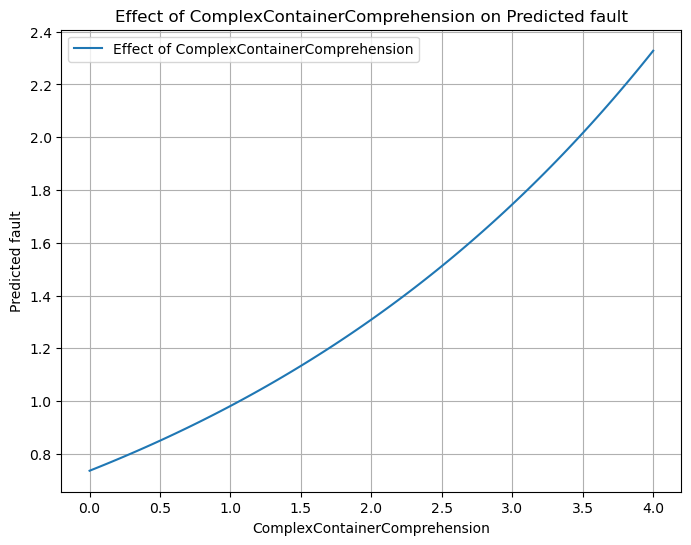

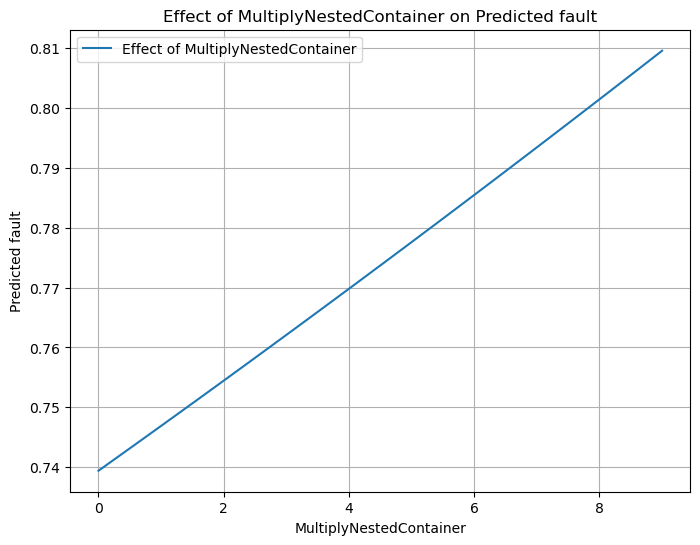

In [30]:
def plot_predictor_effects_fixed(model, predictors, X, df, target_col):
    for predictor in predictors:
        # Generate a sequence of values for the predictor
        x_vals = np.linspace(df[predictor].min(), df[predictor].max(), 100)

        # Create a DataFrame with mean values for all predictors
        X_mean = X.mean().to_frame().T  # DataFrame with one row of means
        X_mean = pd.concat([X_mean] * len(x_vals), ignore_index=True)  # Repeat for the sequence
        X_mean[predictor] = x_vals  # Update the current predictor

        # Predict the expected counts
        predicted = model.predict(X_mean)

        # Plot the effect
        plt.figure(figsize=(8, 6))
        plt.plot(x_vals, predicted, label=f'Effect of {predictor}')
        plt.xlabel(f'{predictor}')
        plt.ylabel(f'Predicted {target_col}')
        plt.title(f'Effect of {predictor} on Predicted {target_col}')
        plt.legend()
        plt.grid()
        plt.show()

# Call the updated function with your data
plot_predictor_effects_fixed(
    model=results,  # The fitted negative binomial regression model
    predictors=columns_to_check,  # List of predictors
    X=X,  # The independent variables with constant column added
    df=whole_df,  # The original DataFrame
    target_col='fault'  # The dependent variable
)
